In [ ]:
%pip install rdkit --quiet
%pip install shapiq -q
%pip install shap -q

In [ ]:
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Chem import Draw, rdDepictor
import numpy as np
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import shapiq
import shap

## Data

In [ ]:
df = pd.read_csv('final_dataset.csv')
df.head()

,smiles,doi,id,group,group_name,MIC,lgMIC,scaffold,group_strat
0,O=C(OCC)C1=C(NC(=O)NC1C=2OC=CC2)CN3C=NC=4C=CC=...,10.1002/cjoc.202200326,5a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.262025,-0.581657,O=C1NC(Cn2cnc3ccccc32)=CC(c2ccco2)N1,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1
1,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,5b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.125508,-0.901328,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1
2,O=C(OCC)C1=C(N(C(=O)N(C1C2=C(C=CS2)C)[H])[H])C...,10.1002/cjoc.202200326,5c,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.121068,-0.916971,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1
3,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6a,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.086704,-1.061962,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1
4,O=C(OCC)C1=C(N(C(=O)N(C1C2=CC=CS2)[H])[H])C[N]...,10.1002/cjoc.202200326,6b,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1,pyrimidinone,0.056148,-1.250666,O=C1NC(Cn2cnc3ccccc32)=CC(c2cccs2)N1,CCOC(=O)C1=C(CN2C=NC3=C2C=CC=C3)NC(=O)NC1


In [ ]:
def get_fingerprint(smiles):
  '''Converts SMILES into Morgan fingerprint'''
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [ ]:
# create fingerprints from SMILES
df['fp'] = df['smiles'].apply(get_fingerprint)

In [ ]:
# split data into predictor and target
X = np.stack(df.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df['lgMIC']#.apply(lambda x: -x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.group_strat)

In [ ]:
# the most promissing scaffolds
groups = ['OC(=O)C1=CNC2=CC(N3CCN(CC3)C3=NC4=C(N3)C=CC=C4)=C(F)C=C2C1=O',
       'OC(=O)C1=CNC2=CC(N3CCN(CC4=NC5=C(N4)C=CC=C5)CC3)=C(F)C=C2C1=O',
       'OC(=O)C1=CNC2=CC(N3CCN(CCC4=NC5=C(N4)C=CC=C5)CC3)=C(F)C=C2C1=O',
       'OC(=O)C1=CNC2=CC(N3CCN(CNC4=NC5=C(N4)C=CC=C5)CC3)=C(F)C=C2C1=O',
        'O=C(CN1C=[N+](CC(=O)C2=CC=CC=C2)C2=C1C=CC=C2)NC1=CC=CC2=CC=CN=C12',
        '[H]N(C(=O)CCN1C=[N+](CC(=O)C2=CC=CC=C2)C2=C1C=CC=C2)C1=CC=CC2=CC=CN=C12']
df1 = df[df.group.isin(groups)]
df1.shape

(50, 10)

In [ ]:
X_scaf = np.stack(df1.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_scaf.shape

(50, 256)

# LGBM Shap

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_scaf)

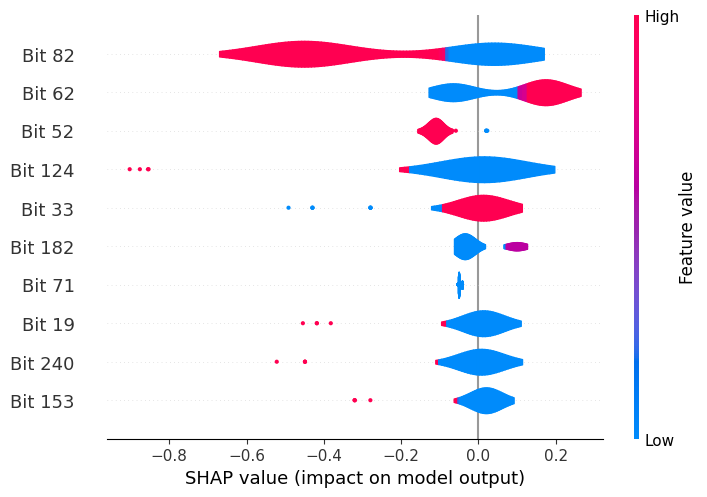

In [ ]:
import matplotlib.pyplot as plt
fig = shap.plots.violin(shap_values, X_scaf, max_display=10, feature_names=[f'Bit {i}' for i in range(256)], show=False)
plt.savefig('shap.png', dpi=500)